In [1]:
import fastai

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from fastai.tabular.all import *

print("Fastai version:", fastai.__version__)

Fastai version: 2.7.16


In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [3]:
# DATA_PATH = '/kaggle/input/titanic'
DATA_PATH = './input'

import os
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input\gender_submission.csv
./input\test.csv
./input\train.csv


In [4]:
train_filename = os.path.join(DATA_PATH, 'train.csv')

train_data = pd.read_csv(train_filename)
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Checking and Filling up missing data

In [5]:
# Check the number of missing values in each column
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# Get the mode of each column
train_data.mode().iloc[0]

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
# Use naive approach to fill missing values using mode
train_data.fillna(train_data.mode().iloc[0], inplace=True)

In [8]:
# Check if the missing values are filled
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Checking the distribution of numerical columns
* For each numerical column, plot a histogram for easy visualization
* For any columns with long-tailed distribution, convert them into normal distribution by taking the log

In [9]:
# Get the summary statistics of the numerical columns
train_data.describe(include='number')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


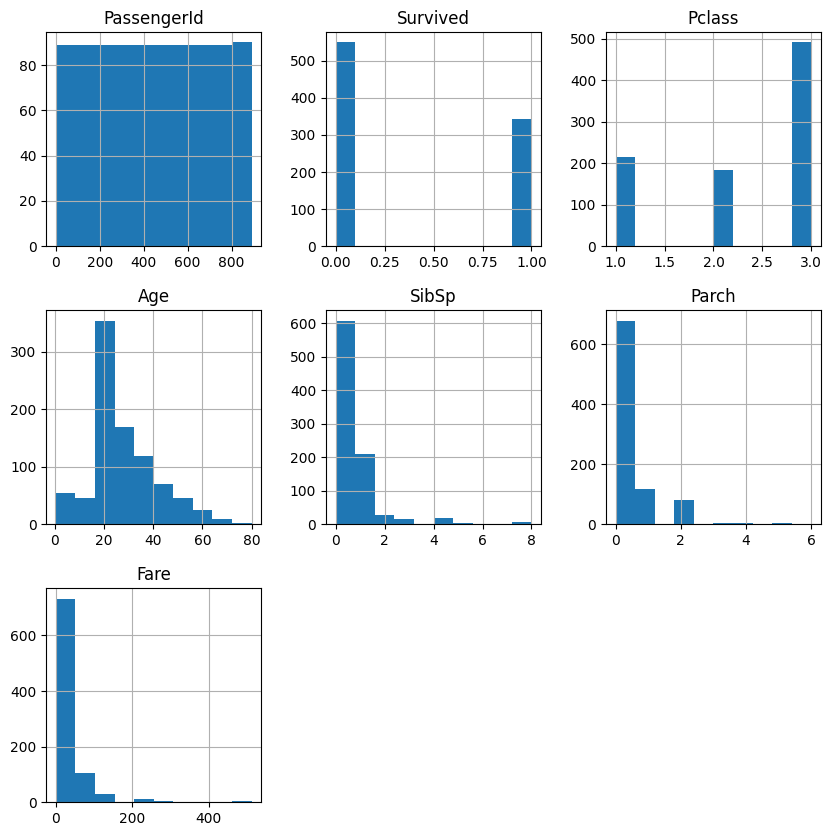

In [10]:
# Plot the distribution of the numerical columns for easy visualization
train_data.hist(figsize=(10, 10))
plt.show()

In [11]:
# Convert fare to normal distribution
train_data['LogFare'] = np.log(train_data['Fare']+1) # +1 to avoid log(0)

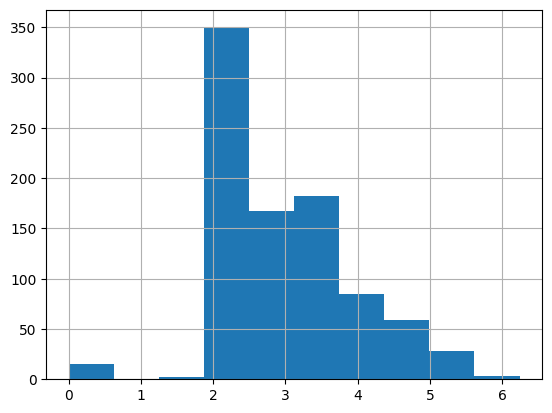

In [12]:
# Plot the distribution of the log transformed fare
train_data['LogFare'].hist()
plt.show()

#### Checking the distribution of columns with type object
* For columns with only a few unique values, convert them into categorical columns

In [13]:
# Check the distribution of the categorical columns
train_data.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [14]:
# Convert columns 'Sex', 'Pclass' and 'Embarked' to category type
train_data = pd.get_dummies(train_data, columns=['Sex', 'Pclass', 'Embarked'])
train_data.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [15]:
# Check the values of the added columns
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
train_data[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,True,False,False,False,True,False,False,True
1,False,True,True,False,False,True,False,False
2,False,True,False,False,True,False,False,True
3,False,True,True,False,False,False,False,True
4,True,False,False,False,True,False,False,True


In [16]:
test_filename = os.path.join(DATA_PATH, 'test.csv')
test_data = pd.read_csv(test_filename)
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [17]:
# Check for missing values in the test data
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [18]:
# Fill missing values in the test data
test_data.fillna(test_data.mode().iloc[0], inplace=True)

In [19]:
# Check if the missing values are filled
test_data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Building a linear model
* Referenced from Fastai course

In [20]:
# Setup dependent and independent variables
t_dep = tensor(train_data['Survived'])

indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(train_data[indep_cols].values.astype(float), dtype=torch.float)

In [21]:
# Check the shape of the dependent and independent variables are correct
t_dep.shape, t_indep.shape

(torch.Size([891]), torch.Size([891, 12]))

In [22]:
torch.manual_seed(442) # To get reproducible results

# Get the number of input neurons
n_coeff = t_indep.shape[1] # Getting the number of weights required, 1 for each column
coeffs = torch.rand(n_coeff)-0.5 # Randomly initializing the weights
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [23]:
vals,indices = t_indep.max(dim=0) # dim 0 is rows, hence get the max value for each column
t_indep = t_indep / vals # Normalizing the input tensor using broadcasting

In [24]:
# Split the data into training and validation sets
from fastai.data.transforms import RandomSplitter
train_split, validation_split = RandomSplitter()(train_data)
train_dep, validation_dep = t_dep[train_split], t_dep[validation_split]
train_indep, validation_indep = t_indep[train_split], t_indep[validation_split]

In [25]:
len(train_dep), len(validation_dep)

(713, 178)

In [26]:
len(train_indep), len(validation_indep)

(713, 178)

In [27]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

In [28]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [29]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, train_indep, train_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [30]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [31]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [32]:
coeffs = train_model(epochs=15, lr=0.2)

0.551; 0.514; 0.483; 0.455; 0.427; 0.400; 0.374; 0.349; 0.331; 0.318; 0.329; 0.300; 0.312; 0.290; 0.297; 

In [33]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.3143),
 'SibSp': tensor(0.1160),
 'Parch': tensor(0.2590),
 'LogFare': tensor(0.0004),
 'Sex_male': tensor(-0.4520),
 'Sex_female': tensor(0.2205),
 'Pclass_1': tensor(0.7300),
 'Pclass_2': tensor(0.3980),
 'Pclass_3': tensor(0.2995),
 'Embarked_C': tensor(0.0402),
 'Embarked_Q': tensor(0.2538),
 'Embarked_S': tensor(0.1861)}

In [34]:
def acc(coeffs): return (validation_dep.bool()==(calc_preds(coeffs, validation_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7472)

In [35]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [36]:
coeffs = train_model(lr=2)

0.509; 0.469; 0.433; 0.403; 0.381; 0.363; 0.348; 0.336; 0.325; 0.316; 0.307; 0.299; 0.293; 0.286; 0.281; 0.276; 0.272; 0.268; 0.264; 0.261; 0.258; 0.255; 0.253; 0.250; 0.248; 0.246; 0.244; 0.243; 0.241; 0.240; 

In [37]:
acc(coeffs)

tensor(0.7360)

In [38]:
show_coeffs()

{'Age': tensor(-0.6548),
 'SibSp': tensor(0.0669),
 'Parch': tensor(0.3053),
 'LogFare': tensor(-0.0032),
 'Sex_male': tensor(-2.5481),
 'Sex_female': tensor(1.7811),
 'Pclass_1': tensor(1.1978),
 'Pclass_2': tensor(0.5076),
 'Pclass_3': tensor(-0.8134),
 'Embarked_C': tensor(-0.0462),
 'Embarked_Q': tensor(0.2850),
 'Embarked_S': tensor(-0.2942)}

### Building NN

In [39]:
# Converting vectors to matrices
train_dep = train_dep[:,None]
validation_dep = validation_dep[:,None]

In [40]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden # Centering the weights around 0
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [41]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps): # Forward pass
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [42]:
def update_coeffs(coeffs, lr): # Backpropagation
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [43]:
coeffs = train_model(lr=1.4)

0.537; 0.526; 0.514; 0.500; 0.484; 0.464; 0.438; 0.406; 0.371; 0.337; 0.310; 0.288; 0.272; 0.259; 0.249; 0.242; 0.236; 0.231; 0.227; 0.224; 0.221; 0.219; 0.217; 0.216; 0.214; 0.213; 0.212; 0.211; 0.210; 0.210; 

In [44]:
acc(coeffs)

tensor(0.7360)

In [45]:
coeffs = train_model(lr=20)

0.537; 0.401; 0.250; 0.401; 0.225; 0.213; 0.207; 0.191; 0.191; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.189; 0.189; 0.189; 

In [46]:
acc(coeffs)

tensor(0.8146)

## Using Fastai instead

In [47]:
# Split into categorical and continuous variables
cat_vars = ['Pclass', 'SibSp', 'Parch', 'Embarked','Sex','Cabin']
cont_vars = ['Age', 'LogFare']

In [48]:
train_data = pd.read_csv(train_filename)

In [49]:
train_data['LogFare'] = np.log(train_data['Fare']+1) # +1 to avoid log(0)

In [50]:
# Split into training and validation set
splits = RandomSplitter(valid_pct=0.2)(range_of(train_data))

# Train an intial model using all the columns in the dataset with fastai
tp = TabularPandas(train_data,
                   procs=[Categorify, FillMissing, Normalize], 
                   cat_names=cat_vars, 
                   cont_names=cont_vars,
                   y_names='Survived',
                   y_block=CategoryBlock(), # To specify single-label classification instead of regression
                   splits=splits)

dls = tp.dataloaders(bs=128)

c:\Users\jared\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastai\tabular\core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [51]:
# Check if the data is loaded correctly
dls.show_batch()

,Pclass,SibSp,Parch,Embarked,Sex,Cabin,Age_na,Age,LogFare,Survived
0,3,1,0,S,female,#na#,False,31.000000,2.944439e+00,0
1,2,0,0,C,female,D,False,23.000000,2.694066e+00,1
2,2,1,1,S,female,#na#,False,26.000000,3.295837e+00,0
3,2,0,0,S,male,#na#,True,28.000000,-5.260307e-08,0
4,1,1,0,S,female,D7,False,63.000002,4.368920e+00,1
5,2,1,1,S,female,#na#,False,40.000000,3.688879e+00,1
6,2,0,0,S,male,D56,False,34.000000,2.639057e+00,1
7,3,2,0,S,male,#na#,False,37.000000,2.188856e+00,0
8,3,0,0,S,male,#na#,True,28.000000,2.185579e+00,0
9,1,0,0,C,male,A5,False,71.000003,3.573867e+00,0


In [52]:
print("Label encoding for categorical data \n")
label_encoding_dict = {cat : tp.procs.categorify[cat].o2i for cat in tp.cat_names}
for cat, encoding in label_encoding_dict.items():
    print(f"{cat} : {encoding}")

Label encoding for categorical data 

Pclass : defaultdict(<class 'int'>, {'#na#': 0, 1: 1, 2: 2, 3: 3})
SibSp : defaultdict(<class 'int'>, {'#na#': 0, 0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 8: 7})
Parch : defaultdict(<class 'int'>, {'#na#': 0, 0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7})
Embarked : defaultdict(<class 'int'>, {'#na#': 0, 'C': 1, 'Q': 2, 'S': 3})
Sex : defaultdict(<class 'int'>, {'#na#': 0, 'female': 1, 'male': 2})
Cabin : defaultdict(<class 'int'>, {'#na#': 0, 'A10': 1, 'A14': 2, 'A16': 3, 'A19': 4, 'A20': 5, 'A23': 6, 'A24': 7, 'A26': 8, 'A31': 9, 'A32': 10, 'A34': 11, 'A36': 12, 'A5': 13, 'A6': 14, 'A7': 15, 'B101': 16, 'B102': 17, 'B18': 18, 'B19': 19, 'B20': 20, 'B22': 21, 'B28': 22, 'B3': 23, 'B30': 24, 'B35': 25, 'B37': 26, 'B38': 27, 'B39': 28, 'B4': 29, 'B41': 30, 'B42': 31, 'B49': 32, 'B5': 33, 'B50': 34, 'B51 B53 B55': 35, 'B57 B59 B63 B66': 36, 'B58 B60': 37, 'B69': 38, 'B71': 39, 'B73': 40, 'B77': 41, 'B78': 42, 'B79': 43, 'B80': 44, 'B82 B84': 45, 'B86': 46, 'B

In [53]:
emb_szs = get_emb_sz(tp)

print("Embedding size associated with each categorical feature:\n")
print({k:v for k,v in zip(tp.cat_names,emb_szs)})


Embedding size associated with each categorical feature:

{'Pclass': (4, 3), 'SibSp': (8, 5), 'Parch': (8, 5), 'Embarked': (4, 3), 'Sex': (3, 3), 'Cabin': (148, 26), 'Age_na': (3, 3)}


In [71]:
# Build the NN with 2 layer - [20, 20 Neurons]
learn = tabular_learner(dls,
                        layers=[10,10],
                        metrics=accuracy)

In [72]:
# Observe model architecture
learn.summary()

TabularModel (Input shape: 128 x 7)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 3             
Embedding                                 12         True      
____________________________________________________________________________
                     128 x 5             
Embedding                                 40         True      
Embedding                                 40         True      
____________________________________________________________________________
                     128 x 3             
Embedding                                 12         True      
Embedding                                 9          True      
____________________________________________________________________________
                     128 x 26            
Embedding                                 3848       True      
____________________________________________________________________________
                     128 x 3            

In [73]:
print("Embedding sizes")
print(learn.embeds)

Embedding sizes
ModuleList(
  (0): Embedding(4, 3)
  (1-2): 2 x Embedding(8, 5)
  (3): Embedding(4, 3)
  (4): Embedding(3, 3)
  (5): Embedding(148, 26)
  (6): Embedding(3, 3)
)


c:\Users\jared\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastai\learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_loc

SuggestedLRs(slide=0.12022644281387329, valley=0.010964781977236271)

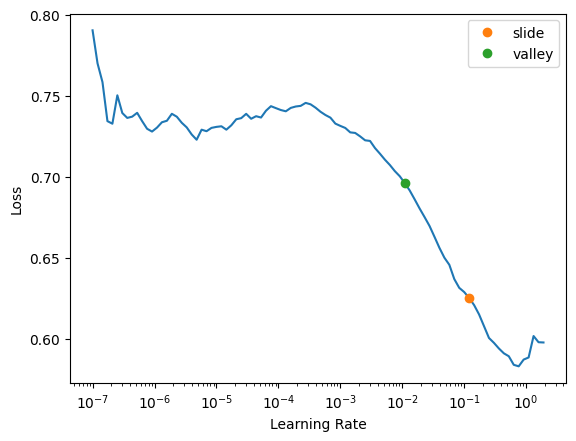

In [74]:
learn.lr_find(suggest_funcs=(slide, valley))

In [75]:
learn.fit_one_cycle(10, lr_max=5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.707960,0.687013,0.713483,00:00
1,0.626965,0.643258,0.601124,00:00
2,0.561359,0.528897,0.797753,00:00
3,0.515823,0.476785,0.797753,00:00
4,0.482951,0.451754,0.837079,00:00
5,0.454138,0.474968,0.825843,00:00
6,0.430667,0.475865,0.820225,00:00
7,0.422133,0.458529,0.837079,00:00
8,0.401405,0.449563,0.837079,00:00
9,0.398946,0.446988,0.837079,00:00


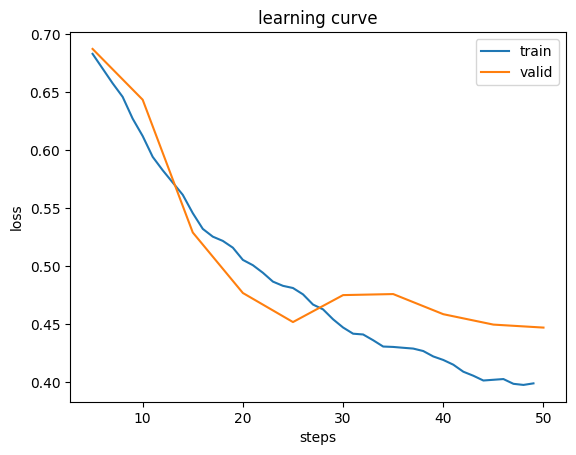

In [76]:
learn.recorder.plot_loss();

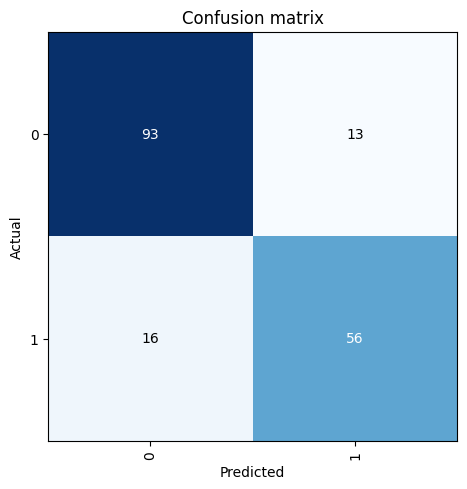

In [77]:
interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix()

In [78]:
interpret.print_classification_report()

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       106
           1       0.81      0.78      0.79        72

    accuracy                           0.84       178
   macro avg       0.83      0.83      0.83       178
weighted avg       0.84      0.84      0.84       178



In [79]:
test_data = pd.read_csv(test_filename)

In [80]:
# Data preprocessing for missing 'Fare' value in test set
fare_median = test_data['Fare'].median()

# Fill missing values with median
test_data.loc[:,'Fare'] = test_data['Fare'].fillna(fare_median)

# Take log of 'Fare', similar to training data
test_data['LogFare'] = np.log(test_data['Fare']+1)

In [81]:
test_dl = learn.dls.test_dl(test_data)
test_dl.process()

preds = learn.get_preds(dl=test_dl)[0].argmax(dim=1).numpy()

c:\Users\jared\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastai\tabular\core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
c:\Users\jared\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastai\tabular\core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on

In [82]:
output = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': preds})
output.to_csv('submission.csv', index=False)
output.head()

,PassengerId,Survived
0,892,1
1,893,1
2,894,1
3,895,1
4,896,1


In [83]:
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1,

### Using Ensembling with NN

In [88]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit_one_cycle(10, lr_max=5e-2)
    return learn.get_preds(dl=test_dl)[0]

In [89]:
learns = [ensemble() for _ in range(5)] # Create 5 separate models

In [90]:
ens_preds = torch.stack(learns).mean(0)

In [91]:
ens_preds = ens_preds.argmax(dim=1).numpy()
ens_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1,